# TODO
### IN ORDER TO FINISH

- Properly test whether the relative loss function achieves a lower final loss
  - Current results suggest it does some times but not a statisticly significant amount, but the improvement appears very very slight

- Test whether the "better" gradient flow with the relative loss results in reaching lower loss values faster

**CONCLUSION** 

Based on prelim observations (note that no formal tests were  done but should  be ) it looks like the regular loss function also achieves lower loss values faster

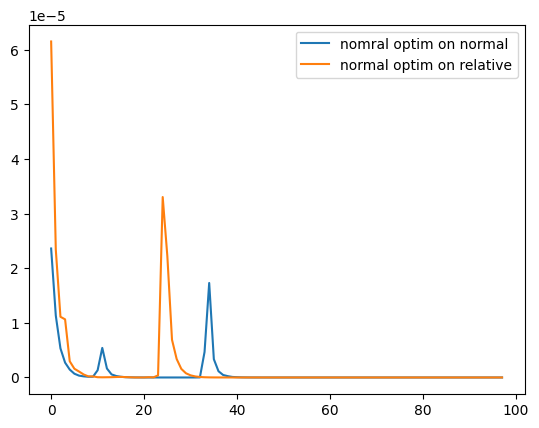

# Side Quest

We were supposed to build an auto-encoder but had a thought: the values of the unnormalized EEG are very small, and consequently the MSE (Mean Squared Error) will be small too. The Euclidean distance between the true and predicted values will likely be small due to the fact that the values are all small. This means the loss will be low and the gradients will be small.

To address this issue, I created a loss function that normalizes by the magnitude of the true vector.

We trained the model multiple times, optimizing using both the standard MSE and the relative MSE, then compared which approach achieved a lower standard MSE.

In [73]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

### Load Data

We will use the Rat EEG data

Since this is an unsupervised method we will not need to use the labels (y values)

In [74]:
path = '/Users/kuba/Documents/data/Raw/pt_ekyn_500hz/000_0.pt'

In [75]:
X, _ = torch.load(path)

In [76]:
X_train, X_dev =  X[:7000], X[7000:]

X_train.shape, X_dev.shape

(torch.Size([7000, 5000]), torch.Size([1640, 5000]))

Let's take a look and establish that the magnitudes of the true samples are small

In [77]:
mags = [torch.sqrt(torch.sum(v ** 2)) for v in X]

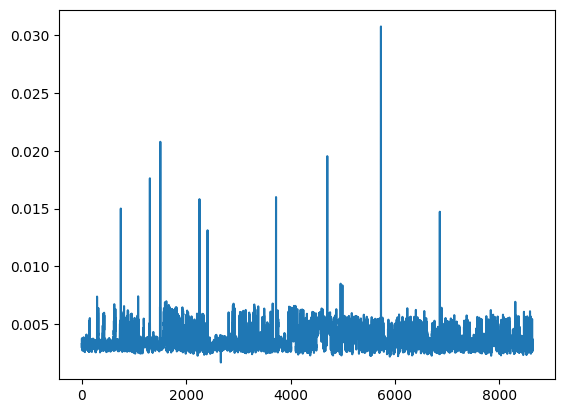

In [78]:
plt.plot(mags)

In [79]:
print(f"The Avg Magnitude is {sum(mags)/len(mags):.4f}")

The Avg Magnitude is 0.0038


These are not very big at all

_____
Lets plot a few samples

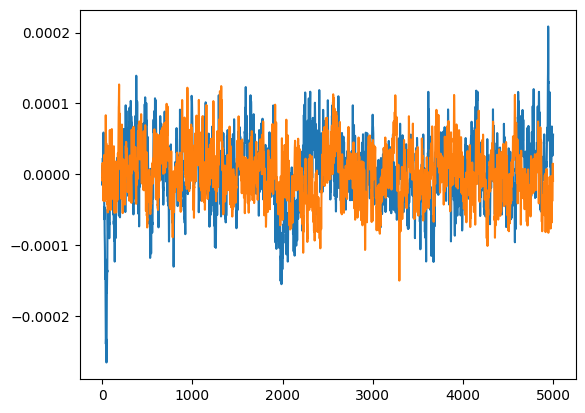

In [80]:
plt.plot(X_train[0])
plt.plot(X_train[500])

Let's generate some vectors that are the same length and the values are sampled randomly between -0.0002 and 0.0002

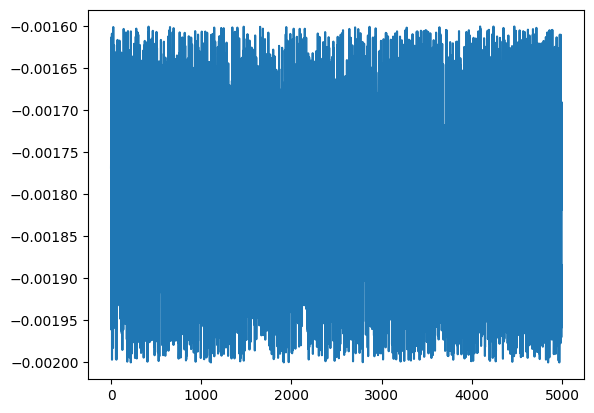

In [81]:
rand_v0 = torch.rand((5000,)) * 0.0004 - 0.002
plt.plot(rand_v0)

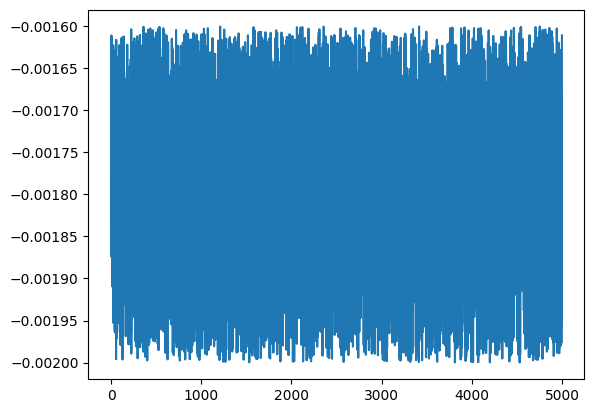

In [82]:
rand_v1 = torch.rand((5000,)) * 0.0004 - 0.002
plt.plot(rand_v1)

the random vecotrs are very clearly not at all close to even looking to the real smaples yet when we calc their MSE loss it will be low

In [83]:
f'{torch.sum((rand_v0 - X_train[0]) ** 2) / len(X_train[0]):.9f}'

'0.000003265'

In [84]:
f'{torch.sum((rand_v1 - X_train[500]) ** 2) / len(X_train[500]):.9f}'


'0.000003262'

Those are very small loss value for somthing thats very wrong
___
But what wopuld those loss values look liek if we normalized on the magnitide of the vector

In [85]:
mag0 = torch.sqrt(torch.sum(X[0] ** 2))
mse0 = torch.sum((rand_v0 - X_train[0]) ** 2) / len(X_train[0])

mag1 = torch.sqrt(torch.sum(X[500] ** 2))
mse1 = torch.sum((rand_v1 - X_train[500]) ** 2) / len(X_train[500])

f'{mse0/mag0:.9f}', f'{mse1/mag1:.9f}'

('0.000998076', '0.001237099')

### MODEL DEF
We make a simple Autoencoder

In [86]:
class MODEL00(nn.Module):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoderl0 = nn.Linear(5000, 2048)
        self.encoderl1 = nn.Linear(2048, 1024)
        self.encoderl2 = nn.Linear(1024, 512)

        self.decoderl0 = nn.Linear(512, 1024)
        self.decoderl1 = nn.Linear(1024, 2048)
        self.decoderl2 = nn.Linear(2048, 5000)
        

    def forward(self, x):
        x = self.encoderl0(x) 
        x = self.encoderl1(x)
        code = self.encoderl2(x)
        x = self.decoderl0(code)
        x = self.decoderl1(x)
        x = self.decoderl2(x)
        return x
    
    def decode(self, code):
        x = self.decoderl0(code)
        x = self.decoderl1(x)
        x = self.decoderl2(x)
        return x

In [87]:
model00 = MODEL00()

In [88]:
#we will use MSE for our standard loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model00.parameters(), lr=0.001)

In [89]:
def relative_mse_loss(pred, true, epsilon=1e-8):
    # Calculates Relative Mean Squared Error
    mse = torch.mean((pred - true) ** 2) #  standard MSE
    magnitude =  torch.sqrt(torch.sum(true ** 2)) # magnitude of true vector
    return mse / magnitude


In [90]:
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=1024)

In [91]:
device = 'mps'
model00 = model00.to(device)

In [92]:
lossi = []

In [93]:
EPOCHS = 100

100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


([<matplotlib.lines.Line2D at 0x118fd6390>], 3.1497443700853214e-09)

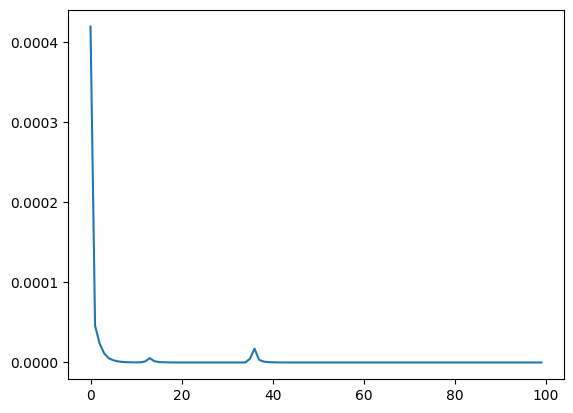

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    loss_total = 0
    
    for train_batch, *_ in train_loader:
        train_batch = train_batch.to(device)
        logits = model00(train_batch)
        #we optimize on the standard MSE
        loss = criterion(logits, train_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item() 

    lossi.append(loss_total / len(train_loader))

plt.plot(lossi), min(lossi)

lest to the same but with the relative loss

In [95]:
model00 = MODEL00()
device = 'mps'
model00 = model00.to(device)

In [96]:
relative_lossi = []
other_lossi = []

In [97]:
optimizer = torch.optim.Adam(model00.parameters(), lr=0.001)

100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


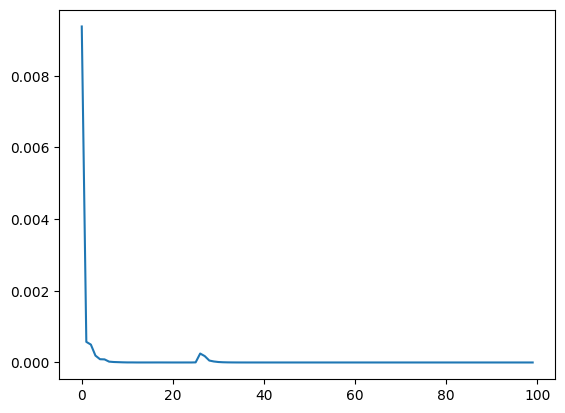

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    loss_total = 0
    other_loss = 0

    for train_batch, *_ in train_loader:
        train_batch = train_batch.to(device)
        logits = model00(train_batch)

        #we will optimize on the relative mse and then calc and store the standard MSE
        loss = relative_mse_loss(logits, train_batch)
        with torch.no_grad():
            other_loss += (criterion(logits, train_batch).item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_total += loss.item() 

    relative_lossi.append(loss_total / len(train_loader))
    other_lossi.append(other_loss / len(train_loader))

plt.plot(relative_lossi, label="Relative loss")
plt.show()

___

Now lets compare the standard MSE loss values for the two way

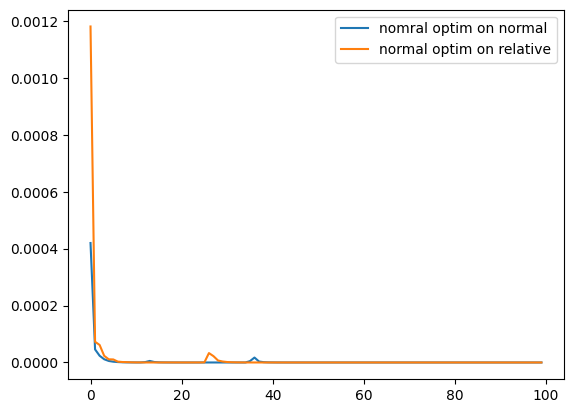

In [99]:
plt.plot(lossi, label="nomral optim on normal")
plt.plot(other_lossi, label="normal optim on relative")
plt.legend()
plt.show()

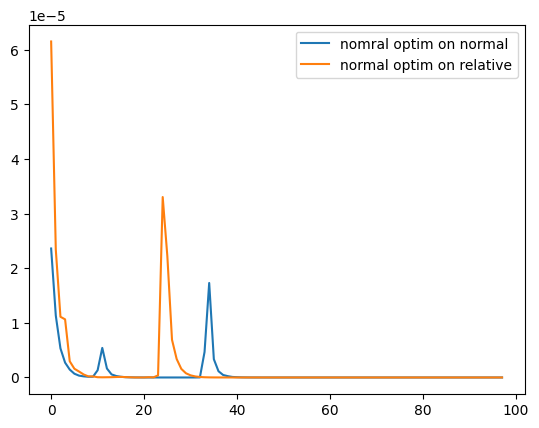

In [110]:
plt.plot(lossi[2:], label="nomral optim on normal")
plt.plot(other_lossi[2:], label="normal optim on relative")
plt.legend()
plt.show()

In [101]:
min(other_lossi) < min(lossi)

False

In [102]:
min(lossi) - min(other_lossi) 

-9.32705658738899e-10

In [103]:
torch.sqrt(torch.sum(torch.tensor([68,96,56,76,45,86]) ** 2))

tensor(179.3683)

In [104]:
torch.mean((torch.tensor([68,96,56,76,45,86], dtype=torch.float32) ** 2))

tensor(5362.1665)

In [105]:
torch.tensor([68,96,56,76,45,86]) ** 2

tensor([4624, 9216, 3136, 5776, 2025, 7396])